## Create a simple forecast from the NDFD which can be used with NWS graphics

In [1]:
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from pyproj import Proj
import pandas as pd
import pytz
from pytz import timezone
from PIL import Image

### Get current time rounded down to last 30 minute interval

In [2]:
def rounded_to_the_last_30_minute():
    now = datetime.now()
    rounded = now - (now - datetime.min) % timedelta(minutes=30)
    return rounded

In [3]:
date = rounded_to_the_last_30_minute()

### Import NDFD data for latest time

In [4]:
YYYYMMDD_HHMM = date.strftime('%Y%m%d_%H%M')
YYYYMMDD_HHMM

'20231218_1600'

In [5]:
File = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NDFD/NWS/CONUS/CONDUIT/NDFD_NWS_CONUS_conduit_2p5km_"+YYYYMMDD_HHMM+".grib2"
File

'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NDFD/NWS/CONUS/CONDUIT/NDFD_NWS_CONUS_conduit_2p5km_20231218_1600.grib2'

In [6]:
ds = xr.open_dataset(File)

0
1
2
3
5


### Parse for data map projection and add lats & lons

In [7]:
ds = ds.metpy.parse_cf()
ds = ds.metpy.assign_latitude_longitude(force=False)
ds

<xarray.Dataset>
Dimensions:                                                                   (
                                                                               time: 3,
                                                                               time_bounds_1: 2,
                                                                               time2: 5,
                                                                               time2_bounds_1: 2,
                                                                               time3: 2,
                                                                               ...
                                                                               time4_bounds_1: 2,
                                                                               x: 2145,
                                                                               y: 1377,
                                                                               time1: 42,
                                                                               height_above_ground1: 1,
                                                                               height_above_ground: 1)
Coordinates: (12/13)
    reftime                                                                   datetime64[ns] ...
  * time                                                                      (time) datetime64[ns] ...
  * time2                                                                     (time2) datetime64[ns] ...
  * time3                                                                     (time3) datetime64[ns] ...
  * time4                                                                     (time4) datetime64[ns] ...
  * x                                                                         (x) float32 ...
    ...                                                                        ...
  * time1                                                                     (time1) datetime64[ns] ...
  * height_above_ground1                                                      (height_above_ground1) float32 ...
    metpy_crs                                                                 object ...
  * height_above_ground                                                       (height_above_ground) float32 ...
    latitude                                                                  (y, x) float64 ...
    longitude                                                                 (y, x) float64 ...
Dimensions without coordinates: time_bounds_1, time2_bounds_1, time3_bounds_1,
                                time4_bounds_1
Data variables: (12/20)
    LambertConformal_Projection                                               int32 ...
    time_bounds                                                               (time, time_bounds_1) datetime64[ns] ...
    time2_bounds                                                              (time2, time2_bounds_1) datetime64[ns] ...
    time3_bounds                                                              (time3, time3_bounds_1) datetime64[ns] ...
    time4_bounds                                                              (time4, time4_bounds_1) datetime64[ns] ...
    Dewpoint_temperature_height_above_ground                                  (time1, height_above_ground1, y, x) float32 ...
    ...                                                                        ...
    Total_snowfall_surface_6_Hour_Accumulation                                (time4, y, x) float32 ...
    Apparent_Temperature_height_above_ground                                  (time1, height_above_ground1, y, x) float32 ...
    Weather_string_surface                                                    (time1, y, x) float32 ...
    Wind_direction_from_which_blowing_height_above_ground                     (time1, height_above_ground, y, x) float32 ...
    Wind_speed_height_above_ground                                       

In [8]:
x, y = ds.x, ds.y

### Define max temp variable & function to get closest gridpoint to ETEC

In [9]:
max_temp = ds.Maximum_temperature_height_above_ground_12_Hour_Maximum

In [10]:
def find_closest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

### Get gridpoint closest to ETEC

In [11]:
proj_data = max_temp.metpy.cartopy_crs
proj_data;

pFull = Proj(proj_data)

In [12]:
siteName = "ETEC"
siteLat, siteLon = (42.68, -73.81) #lat & lon of gridpoint over ETEC
siteX, siteY = pFull(siteLon, siteLat)
siteXidx, siteYidx = find_closest(x, siteX), find_closest(y, siteY)

### Define and index wind speed variable

In [13]:
windSpeed = ds.Wind_speed_height_above_ground
windSpeed = windSpeed.isel(x = siteXidx, y = siteYidx).isel()

timeDimWind, vertDimWind = windSpeed.metpy.time.name, windSpeed.metpy.vertical.name

idxVertWind = 0 # First (and in this case, only) vertical level

vertDictWind = {vertDimWind: idxVertWind}

forecastWindSpeed = windSpeed.isel(vertDictWind)

### Index max temp variable

In [14]:
forecastMax = max_temp.isel(x = siteXidx, y = siteYidx).isel()

timeDimMax, vertDimMax = forecastMax.metpy.time.name, forecastMax.metpy.vertical.name

idxTimeTemp = slice(None, 2) # First time
idxVertTemp = 0 # First (and in this case, only) vertical level

timeDictMax = {timeDimMax: idxTimeTemp}
vertDictMax = {vertDimMax: idxVertTemp}

forecastMax = forecastMax.isel(vertDictMax).isel(timeDictMax)
forecastMax = forecastMax.metpy.convert_units('degF')

### import and index min temp variable

In [15]:
min_temp = ds.Minimum_temperature_height_above_ground_12_Hour_Minimum

forecastMin = min_temp.isel(x = siteXidx, y = siteYidx).isel()

timeDimMin, vertDimMin = forecastMin.metpy.time.name, forecastMin.metpy.vertical.name

timeDictMin = {timeDimMin: idxTimeTemp}
vertDictMin = {vertDimMin: idxVertTemp}

forecastMin = forecastMin.isel(vertDictMin).isel(timeDictMin)
forecastMin = forecastMin.metpy.convert_units('degF')

### import and index precip chance variable

In [16]:
precip = ds.Total_precipitation_surface_12_Hour_Accumulation_probability_above_0p254

forecastPrecip = precip.isel(x = siteXidx, y = siteYidx).isel()

timeDimPrecip = forecastPrecip.metpy.time.name

idxTimeFull = slice(None, 4) # First 4 times

timeDictPrecip = {timeDimPrecip: idxTimeFull}

forecastPrecip = forecastPrecip.isel(timeDictPrecip)

### Import and index cloud cover variable

In [17]:
cloudCover = ds.Total_cloud_cover_surface

forecastCloudCover = cloudCover.isel(x = siteXidx, y = siteYidx).isel()

timeDimCloudCover = forecastCloudCover.metpy.time.name

#### Define variable fro 6-hr precip accumulation (really just need it to get the 6-hr interval)

In [18]:
precip6hr = ds.Total_precipitation_surface_6_Hour_Accumulation

### Define 1hr, 6hr, 12hr time steps

In [19]:
times1 = forecastCloudCover.metpy.time.values
times6 = precip6hr.metpy.time.values
times12 = forecastPrecip.metpy.time.values

### Import weather strings from csv

In [20]:
url = 'https://www.atmos.albany.edu/products/ndfd/northeast/ALB_Wx_latest.csv'
#this is for 42.75, -73.80, technically a different gridpoint but close enough
wx = pd.read_csv(url)
wx = wx.rename(columns = {' validTime': 'validTime', ' (42.750000': 'Wx String'})
wx['validTime'] = wx['validTime'].astype(str)
wx['validTime'] = pd.to_datetime(wx['validTime'])

wx['Wx String'] = wx['Wx String'].str.strip()

wx

,element,unit,refTime,validTime,Wx String,-73.800000)
0,Wx,[-],202312181600,2023-12-18 18:00:00,Definite Moderate Rain,NaN
1,Wx,[-],202312181600,2023-12-18 21:00:00,Likely Light Rain Showers,NaN
2,Wx,[-],202312181600,2023-12-19 00:00:00,No Weather,NaN
3,Wx,[-],202312181600,2023-12-19 03:00:00,No Weather,NaN
4,Wx,[-],202312181600,2023-12-19 06:00:00,No Weather,NaN
5,Wx,[-],202312181600,2023-12-19 09:00:00,Chance of Light Rain Showers,NaN
6,Wx,[-],202312181600,2023-12-19 12:00:00,Chance of Light Rain Showers and Chance of Lig...,NaN
7,Wx,[-],202312181600,2023-12-19 15:00:00,Chance of Light Rain Showers and Chance of Lig...,NaN
8,Wx,[-],202312181600,2023-12-19 18:00:00,Slight Chance of Light Snow Showers,NaN
9,Wx,[-],202312181600,2023-12-19 21:00:00,Slight Chance of Light Snow Showers,NaN


### Define weather string and its valid time

In [21]:
wxTimes = wx['validTime']
wxStr = wx['Wx String']

### Define function to get sky cover string

In [22]:
def skyConditionFromCloudCover(cloudCover):
    if 0 <= cloudCover <= 5:
        skyCondition = 'Clear'
    elif 6 <= cloudCover <= 25:
        skyCondition = 'Mostly Clear'
    elif 26 <= cloudCover <= 50:
        skyCondition = 'Partly Cloudy'
    elif 51 <= cloudCover <= 87:
        skyCondition = 'Mostly Cloudy'
    elif 88 <= cloudCover <= 100:
        skyCondition = 'Overcast'
    return skyCondition

### Define function to get wind string from wind speed

In [23]:
def windStrFromWindSpeed(wdsp):
    if 0 <= wdsp <= 6.7:
        windStr = 'Calm'
    elif 6.7 < wdsp <= 8.9:
        windStr = 'Breezy'
    elif 8.9 < wdsp <= 13.4:
        windStr = 'Windy'
    elif 13.4 < wdsp <= 17.9:
        windStr = 'Very Windy'
    elif wdsp > 17.9:
        windStr = 'Strong Wind'
    return windStr

### Define function to output most common string from a list

In [24]:
def most_common(lst):
    return max(set(lst), key=lst.count)

### Check if the first 6-hour time step starts at or before the first 12-hour time step

In [25]:
timecheck = times12[0] + np.timedelta64(1, 'h')
#sometimes the 12-hour time is 1 hour behind so the time check account for that

In [26]:
i = 0

times6check = []

for times in times6:
    
    if times <= timecheck:
        times6check.append(times)
    else:
        pass
    
    i = i+1

In [27]:
if len(times6check) == 2:
    nice_time = True
elif len(times6check) == 1:
    nice_time = False

### Create lists of wind speed for each 6-hr period to use for updating conditions

In [28]:
if nice_time == True:

    iWind = 0

    windSpeedList_11 = []

    for wind_time_step in times1:

        if wind_time_step <= times6[0]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_11.append(windStr)
            else:
                pass

        iWind = iWind + 1

    if not windSpeedList_11: 
        wdsp_11 = forecastWindSpeed.values[0]
        windSpeedList_11.append(wdsp_11)    

    wdsp_11 = most_common(windSpeedList_11)
    #windSpeedList_11
    #wdsp_11

    iWind = 0

    windSpeedList_12 = []

    for wind_time_step in times1:

        if times6[0] < wind_time_step <= times6[1]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_12.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_12 = most_common(windSpeedList_12)
    #windSpeedList_12
    #wdsp_12
    
elif nice_time == False:
    
    iWind = 0

    windSpeedList_11 = []

    for wind_time_step in times1:

        if wind_time_step <= times12[0]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_11.append(windStr)
            else:
                pass

        iWind = iWind + 1

    if not windSpeedList_11: 
        wdsp_11 = forecastWindSpeed.values[0]
        windSpeedList_11.append(wdsp_11)    

    wdsp_11 = most_common(windSpeedList_11)
    wdsp_12 = wdsp_11
    #windSpeedList_11
    #wdsp_11

In [29]:
if nice_time == True:

    iWind = 0

    windSpeedList_21 = []

    for wind_time_step in times1:

        if times6[1] < wind_time_step <= times6[2]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_21.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_21 = most_common(windSpeedList_21)
    #windSpeedList_21
    #wdsp_21

    iWind = 0

    windSpeedList_22 = []

    for wind_time_step in times1:

        if times6[2] < wind_time_step <= times6[3]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_22.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_22 = most_common(windSpeedList_22)
    #windSpeedList_22
    #wdsp_22
    
elif nice_time == False:

    iWind = 0

    windSpeedList_21 = []

    for wind_time_step in times1:

        if times6[0] < wind_time_step <= times6[1]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_21.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_21 = most_common(windSpeedList_21)
    #windSpeedList_21
    #wdsp_21

    iWind = 0

    windSpeedList_22 = []

    for wind_time_step in times1:

        if times6[1] < wind_time_step <= times6[2]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_22.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_22 = most_common(windSpeedList_22)
    #windSpeedList_22
    #wdsp_22

In [30]:
if nice_time == True:

    iWind = 0

    windSpeedList_31 = []

    for wind_time_step in times1:

        if times6[3] < wind_time_step <= times6[4]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_31.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_31 = most_common(windSpeedList_31)
    #windSpeedList_31
    #wdsp_31

    iWind = 0

    windSpeedList_32 = []

    for wind_time_step in times1:

        if times6[4] < wind_time_step <= times6[5]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_32.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_32 = most_common(windSpeedList_32)
    #windSpeedList_32
    #wdsp_32
    
elif nice_time == False:
    
    iWind = 0

    windSpeedList_31 = []

    for wind_time_step in times1:

        if times6[2] < wind_time_step <= times6[3]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_31.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_31 = most_common(windSpeedList_31)
    #windSpeedList_31
    #wdsp_31

    iWind = 0

    windSpeedList_32 = []

    for wind_time_step in times1:

        if times6[3] < wind_time_step <= times6[4]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_32.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_32 = most_common(windSpeedList_32)
    #windSpeedList_32
    #wdsp_32

In [31]:
if nice_time == True:

    iWind = 0

    windSpeedList_41 = []

    for wind_time_step in times1:

        if times6[5] < wind_time_step <= times6[6]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_41.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_41 = most_common(windSpeedList_41)
    #windSpeedList_41
    #wdsp_41

    iWind = 0

    windSpeedList_42 = []

    for wind_time_step in times1:

        if times6[6] < wind_time_step <= times6[7]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_42.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_42 = most_common(windSpeedList_42)
    #windSpeedList_42
    #wdsp_42
    
elif nice_time == False:
    
    iWind = 0

    windSpeedList_41 = []

    for wind_time_step in times1:

        if times6[4] < wind_time_step <= times6[5]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_41.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_41 = most_common(windSpeedList_41)
    #windSpeedList_41
    #wdsp_41

    iWind = 0

    windSpeedList_42 = []

    for wind_time_step in times1:

        if times6[5] < wind_time_step <= times6[6]:
            timeDictWind = {timeDimWind: iWind}
            forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)

            nanCheck = forecastWindSpeedNew.isnull().values

            if nanCheck == False:
                windStr = windStrFromWindSpeed(forecastWindSpeedNew)

                windSpeedList_42.append(windStr)
            else:
                pass

        iWind = iWind + 1

    wdsp_42 = most_common(windSpeedList_42)
    #windSpeedList_42
    #wdsp_42

### Define weather for each 6 hour period

In [32]:
if nice_time == True:

    wxlist_11 = []

    for wx_time_step in wxTimes:

        if date < wx_time_step <= times6[0]:
            wx_11 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_11.append(wx_11)

    count = wxlist_11.count('No Weather')      

    if not wxlist_11: 
        wx_11 = wx['Wx String'][0]

    #this just exists beacsue sometimes the times dont line up well and there is no actual forecast weather string
    #for the first '6 hour' period so it just grabs the very first weather string

    elif len(wxlist_11) == 1 and count == 1:
        wx_11 = most_common(wxlist_11)

    else:
        if count > 1:
            wx_11 = 'No Weather'

        elif count > 0:
            wxlist_11.remove('No Weather')
            wx_11 = most_common(wxlist_11)

        elif count == 0:
            wx_11 = most_common(wxlist_11)

    #wxlist_11
    #wx_11

    wxlist_12 = []

    for wx_time_step in wxTimes:

        if times6[0] < wx_time_step <= times6[1]:
            wx_12 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_12.append(wx_12)

    count = wxlist_12.count('No Weather') 

    if len(wxlist_12) == 1 and count == 1:
        wx_12 = most_common(wxlist_12)

    elif count > 1:
        wx_12 = 'No Weather'

    elif count > 0:
        wxlist_12.remove('No Weather')
        wx_12 = most_common(wxlist_12)

    elif count == 0:
        wx_12 = most_common(wxlist_12)

    #wxlist_12
    #wx_12
    
elif nice_time == False:

    wxlist_11 = []

    for wx_time_step in wxTimes:

        if date < wx_time_step <= times12[0]:
            wx_11 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_11.append(wx_11)

    count = wxlist_11.count('No Weather')      

    if not wxlist_11: 
        wx_11 = wx['Wx String'][0]

    #this just exists beacsue sometimes the times dont line up well and there is no actual forecast weather string
    #for the first '6 hour' period so it just grabs the very first weather string

    elif len(wxlist_11) == 1 and count == 1:
        wx_11 = most_common(wxlist_11)

    else:
        if count > 1:
            wx_11 = 'No Weather'

        elif count > 0:
            wxlist_11.remove('No Weather')
            wx_11 = most_common(wxlist_11)

        elif count == 0:
            wx_11 = most_common(wxlist_11)

    #wxlist_11
    #wx_11
    wx_12 = wx_11

In [33]:
if nice_time == True:

    wxlist_21 = []

    for wx_time_step in wxTimes:

        if times6[1] < wx_time_step <= times6[2]:
            wx_21 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_21.append(wx_21)

    count = wxlist_21.count('No Weather') 

    if len(wxlist_21) == 1 and count == 1:
        wx_21 = most_common(wxlist_21)

    elif count > 1:
        wx_21 = 'No Weather'

    elif count > 0:
        wxlist_21.remove('No Weather')
        wx_21 = most_common(wxlist_21)

    elif count == 0:
        wx_21 = most_common(wxlist_21)

    #wx_21

    wxlist_22 = []

    for wx_time_step in wxTimes:

        if times6[2] < wx_time_step <= times6[3]:
            wx_22 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_22.append(wx_22)

    count = wxlist_22.count('No Weather') 

    if len(wxlist_22) == 1 and count == 1:
        wx_22 = most_common(wxlist_22)

    elif count > 1:
        wx_22 = 'No Weather'

    elif count > 0:
        wxlist_22.remove('No Weather')
        wx_22 = most_common(wxlist_22)

    elif count == 0:
        wx_22 = most_common(wxlist_22)

    #wx_22
    
if nice_time == False:

    wxlist_21 = []

    for wx_time_step in wxTimes:

        if times6[0] < wx_time_step <= times6[1]:
            wx_21 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_21.append(wx_21)

    count = wxlist_21.count('No Weather') 

    if len(wxlist_21) == 1 and count == 1:
        wx_21 = most_common(wxlist_21)

    elif count > 1:
        wx_21 = 'No Weather'

    elif count > 0:
        wxlist_21.remove('No Weather')
        wx_21 = most_common(wxlist_21)

    elif count == 0:
        wx_21 = most_common(wxlist_21)

    #wx_21

    wxlist_22 = []

    for wx_time_step in wxTimes:

        if times6[1] < wx_time_step <= times6[2]:
            wx_22 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_22.append(wx_22)

    count = wxlist_22.count('No Weather') 

    if len(wxlist_22) == 1 and count == 1:
        wx_22 = most_common(wxlist_22)

    elif count > 1:
        wx_22 = 'No Weather'

    elif count > 0:
        wxlist_22.remove('No Weather')
        wx_22 = most_common(wxlist_22)

    elif count == 0:
        wx_22 = most_common(wxlist_22)

    #wx_22

In [34]:
if nice_time == True:

    wxlist_31 = []

    for wx_time_step in wxTimes:

        if times6[3] < wx_time_step <= times6[4]:
            wx_31 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_31.append(wx_31)

    count = wxlist_31.count('No Weather') 

    if len(wxlist_31) == 1 and count == 1:
        wx_31 = most_common(wxlist_31)

    elif count > 1:
        wx_31 = 'No Weather'

    elif count > 0:
        wxlist_31.remove('No Weather')
        wx_31 = most_common(wxlist_31)

    elif count == 0:
        wx_31 = most_common(wxlist_31)

    #wx_31

    wxlist_32 = []

    for wx_time_step in wxTimes:

        if times6[4] < wx_time_step <= times6[5]:
            wx_32 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_32.append(wx_32)

    count = wxlist_32.count('No Weather') 

    if len(wxlist_32) == 1 and count == 1:
        wx_32 = most_common(wxlist_32)

    elif count > 1:
        wx_32 = 'No Weather'

    elif count > 0:
        wxlist_32.remove('No Weather')
        wx_32 = most_common(wxlist_32)

    elif count == 0:
        wx_32 = most_common(wxlist_32)

    #wx_32
    
if nice_time == False:

    wxlist_31 = []

    for wx_time_step in wxTimes:

        if times6[2] < wx_time_step <= times6[3]:
            wx_31 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_31.append(wx_31)

    count = wxlist_31.count('No Weather') 

    if len(wxlist_31) == 1 and count == 1:
        wx_31 = most_common(wxlist_31)

    elif count > 1:
        wx_31 = 'No Weather'

    elif count > 0:
        wxlist_31.remove('No Weather')
        wx_31 = most_common(wxlist_31)

    elif count == 0:
        wx_31 = most_common(wxlist_31)

    #wx_31

    wxlist_32 = []

    for wx_time_step in wxTimes:

        if times6[3] < wx_time_step <= times6[4]:
            wx_32 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_32.append(wx_32)

    count = wxlist_32.count('No Weather') 

    if len(wxlist_32) == 1 and count == 1:
        wx_32 = most_common(wxlist_32)

    elif count > 1:
        wx_32 = 'No Weather'

    elif count > 0:
        wxlist_32.remove('No Weather')
        wx_32 = most_common(wxlist_32)

    elif count == 0:
        wx_32 = most_common(wxlist_32)

    #wx_32

In [35]:
if nice_time == True:

    wxlist_41 = []

    for wx_time_step in wxTimes:

        if times6[5] < wx_time_step <= times6[6]:
            wx_41 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_41.append(wx_41)

    count = wxlist_41.count('No Weather') 

    if len(wxlist_41) == 1 and count == 1:
        wx_41 = most_common(wxlist_41)

    elif count > 1:
        wx_41 = 'No Weather'

    elif count > 0:
        wxlist_41.remove('No Weather')
        wx_41 = most_common(wxlist_41)

    elif count == 0:
        wx_41 = most_common(wxlist_41)

    #wx_41

    wxlist_42 = []

    for wx_time_step in wxTimes:

        if times6[6] < wx_time_step <= times6[7]:
            wx_42 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_42.append(wx_42)

    count = wxlist_42.count('No Weather') 

    if len(wxlist_42) == 1 and count == 1:
        wx_42 = most_common(wxlist_42)

    elif count > 1:
        wx_42 = 'No Weather'

    elif count > 0:
        wxlist_42.remove('No Weather')
        wx_42 = most_common(wxlist_42)

    elif count == 0:
        wx_42 = most_common(wxlist_42)

    #wx_42
    
elif nice_time == False:

    wxlist_41 = []

    for wx_time_step in wxTimes:

        if times6[4] < wx_time_step <= times6[5]:
            wx_41 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_41.append(wx_41)

    count = wxlist_41.count('No Weather') 

    if len(wxlist_41) == 1 and count == 1:
        wx_41 = most_common(wxlist_41)

    elif count > 1:
        wx_41 = 'No Weather'

    elif count > 0:
        wxlist_41.remove('No Weather')
        wx_41 = most_common(wxlist_41)

    elif count == 0:
        wx_41 = most_common(wxlist_41)

    #wx_41

    wxlist_42 = []

    for wx_time_step in wxTimes:

        if times6[5] < wx_time_step <= times6[6]:
            wx_42 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]

            wxlist_42.append(wx_42)

    count = wxlist_42.count('No Weather') 

    if len(wxlist_42) == 1 and count == 1:
        wx_42 = most_common(wxlist_42)

    elif count > 1:
        wx_42 = 'No Weather'

    elif count > 0:
        wxlist_42.remove('No Weather')
        wx_42 = most_common(wxlist_42)

    elif count == 0:
        wx_42 = most_common(wxlist_42)

    #wx_42

### Loops through weather strings and calculates cloud cover if there is no weather

In [36]:
if nice_time == True:
    
    if wx_11 == 'No Weather' and wx_12 == 'No Weather':

        i = 0

        noWx1 = True

        cloudCoverList_1 = []

        for cloud_time_step in times1:

            if cloud_time_step <= times12[0]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                nanCheck = forecastCloudCoverNew.isnull().values 

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_1.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_1 = most_common(cloudCoverList_1)

    elif wx_11 == 'No Weather':

        i = 0

        noWx1 = False
        cc_wx1 = True


        cloudCoverList_11 = []

        for cloud_time_step in times1:

            if cloud_time_step <= times6[0]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_11.append(skyCover)
                else:
                    pass

            i = i + 1

        if not cloudCoverList_11: 
            cc_11 = forecastCloudCover.values[0]
            cloudCoverList_11.append(cc_11)  

        cc_11 = most_common(cloudCoverList_11)

    elif wx_12 == 'No Weather':

        i = 0

        noWx1 = False
        cc_wx1 = False
        wx_cc1 = True

        cloudCoverList_12 = []

        for cloud_time_step in times1:

            if times6[0] < cloud_time_step <= times6[1]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_12.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_12 = most_common(cloudCoverList_12)

    elif wx_11 != 'No Weather' and wx_12 != 'No Weather':
        noWx1 = False
        cc_wx1 = False
        wx_cc1 = False
        wx1 = True
        
elif nice_time == False:
    
    if wx_11 == 'No Weather':

        i = 0

        noWx1 = True

        cloudCoverList_1 = []

        for cloud_time_step in times1:

            if cloud_time_step <= times12[0]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                nanCheck = forecastCloudCoverNew.isnull().values 

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_1.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_1 = most_common(cloudCoverList_1)  
    
    elif wx_11 != 'No Weather':
        noWx1 = False
        cc_wx1 = False
        wx_cc1 = False
        wx1 = True

In [37]:
if nice_time == True:

    if wx_21 == 'No Weather' and wx_22 == 'No Weather':

        i = 0

        noWx2 = True

        cloudCoverList_2 = []

        for cloud_time_step in times1:

            if times12[0] < cloud_time_step <= times12[1]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_2.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_2 = most_common(cloudCoverList_2)

    elif wx_21 == 'No Weather':

        i = 0

        noWx2 = False
        cc_wx2 = True

        cloudCoverList_21 = []

        for cloud_time_step in times1:

            if times6[1] < cloud_time_step <= times6[2]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_21.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_21 = most_common(cloudCoverList_21)

    elif wx_22 == 'No Weather':

        i = 0

        noWx2 = False
        cc_wx2 = False
        wx_cc2 = True

        cloudCoverList_22 = []

        for cloud_time_step in times1:

            if times6[2] < cloud_time_step <= times6[3]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_22.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_22 = most_common(cloudCoverList_22)

    elif wx_21 != 'No Weather' and wx_22 != 'No Weather':
        noWx2 = False
        cc_wx2 = False
        wx_cc2 = False
        wx2 = True
        
elif nice_time == False:

    if wx_21 == 'No Weather' and wx_22 == 'No Weather':

        i = 0

        noWx2 = True

        cloudCoverList_2 = []

        for cloud_time_step in times1:

            if times12[0] < cloud_time_step <= times12[1]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_2.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_2 = most_common(cloudCoverList_2)

    elif wx_21 == 'No Weather':

        i = 0

        noWx2 = False
        cc_wx2 = True

        cloudCoverList_21 = []

        for cloud_time_step in times1:

            if times6[0] < cloud_time_step <= times6[1]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_21.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_21 = most_common(cloudCoverList_21)

    elif wx_22 == 'No Weather':

        i = 0

        noWx2 = False
        cc_wx2 = False
        wx_cc2 = True

        cloudCoverList_22 = []

        for cloud_time_step in times1:

            if times6[1] < cloud_time_step <= times6[2]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_22.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_22 = most_common(cloudCoverList_22)

    elif wx_21 != 'No Weather' and wx_22 != 'No Weather':
        noWx2 = False
        cc_wx2 = False
        wx_cc2 = False
        wx2 = True

In [38]:
if nice_time == True:

    if wx_31 == 'No Weather' and wx_32 == 'No Weather':

        i = 0

        noWx3 = True

        cloudCoverList_3 = []

        for cloud_time_step in times1:

            if times12[1] < cloud_time_step <= times12[2]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_3.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_3 = most_common(cloudCoverList_3)

    elif wx_31 == 'No Weather':

        i = 0

        noWx3 = False
        cc_wx3 = True

        cloudCoverList_31 = []

        for cloud_time_step in times1:

            if times6[3] < cloud_time_step <= times6[4]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_31.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_31 = most_common(cloudCoverList_31)

    elif wx_32 == 'No Weather':

        i = 0

        noWx3 = False
        cc_wx3 = False
        wx_cc3 = True

        cloudCoverList_32 = []

        for cloud_time_step in times1:

            if times6[4] < cloud_time_step <= times6[5]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_32.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_32 = most_common(cloudCoverList_32)

    elif wx_31 != 'No Weather' and wx_32 != 'No Weather':
        noWx3 = False
        cc_wx3 = False
        wx_cc3 = False
        wx3 = True
        
elif nice_time == False:

    if wx_31 == 'No Weather' and wx_32 == 'No Weather':

        i = 0

        noWx3 = True

        cloudCoverList_3 = []

        for cloud_time_step in times1:

            if times12[1] < cloud_time_step <= times12[2]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_3.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_3 = most_common(cloudCoverList_3)

    elif wx_31 == 'No Weather':

        i = 0

        noWx3 = False
        cc_wx3 = True

        cloudCoverList_31 = []

        for cloud_time_step in times1:

            if times6[2] < cloud_time_step <= times6[3]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_31.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_31 = most_common(cloudCoverList_31)

    elif wx_32 == 'No Weather':

        i = 0

        noWx3 = False
        cc_wx3 = False
        wx_cc3 = True

        cloudCoverList_32 = []

        for cloud_time_step in times1:

            if times6[3] < cloud_time_step <= times6[4]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_32.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_32 = most_common(cloudCoverList_32)

    elif wx_31 != 'No Weather' and wx_32 != 'No Weather':
        noWx3 = False
        cc_wx3 = False
        wx_cc3 = False
        wx3 = True

In [39]:
if nice_time == True:

    if wx_41 == 'No Weather' and wx_42 == 'No Weather':

        i = 0

        noWx4 = True

        cloudCoverList_4 = []

        for cloud_time_step in times1:

            if times12[2] < cloud_time_step <= times12[3]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_4.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_4 = most_common(cloudCoverList_4)

    elif wx_41 == 'No Weather':

        i = 0

        noWx4 = False
        cc_wx4 = True

        cloudCoverList_41 = []

        for cloud_time_step in times1:

            if times6[5] < cloud_time_step <= times6[6]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_41.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_41 = most_common(cloudCoverList_41)

    elif wx_42 == 'No Weather':

        i = 0

        noWx4 = False
        cc_wx4 = False
        wx_cc4 = True

        cloudCoverList_42 = []

        for cloud_time_step in times1:

            if times6[6] < cloud_time_step <= times6[7]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_42.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_42 = most_common(cloudCoverList_42)

    elif wx_41 and wx_42 != 'No Weather':
        noWx4 = False
        cc_wx4 = False
        wx_cc4 = False
        wx4 = True
        
elif nice_time == False:

    if wx_41 == 'No Weather' and wx_42 == 'No Weather':

        i = 0

        noWx4 = True

        cloudCoverList_4 = []

        for cloud_time_step in times1:

            if times12[2] < cloud_time_step <= times12[3]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_4.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_4 = most_common(cloudCoverList_4)

    elif wx_41 == 'No Weather':

        i = 0

        noWx4 = False
        cc_wx4 = True

        cloudCoverList_41 = []

        for cloud_time_step in times1:

            if times6[4] < cloud_time_step <= times6[5]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_41.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_41 = most_common(cloudCoverList_41)

    elif wx_42 == 'No Weather':

        i = 0

        noWx4 = False
        cc_wx4 = False
        wx_cc4 = True

        cloudCoverList_42 = []

        for cloud_time_step in times1:

            if times6[5] < cloud_time_step <= times6[6]:
                timeDictCloudCover = {timeDimCloudCover: i}
                forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)

                if nanCheck == False:
                    skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)

                    cloudCoverList_42.append(skyCover)
                else:
                    pass

            i = i + 1

        cc_42 = most_common(cloudCoverList_42)

    elif wx_41 and wx_42 != 'No Weather':
        noWx4 = False
        cc_wx4 = False
        wx_cc4 = False
        wx4 = True

In [40]:
def to_datetime(date):
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

In [41]:
eastern = timezone('US/Eastern')

In [42]:
i=0
imax=0
imin=0

print('----------------')

for time_step in times12:
    
    period = i+1
    periodStr = str(period)
    
    print('Forecast Period: '+ periodStr)
    
    timeStamp = to_datetime(time_step)
    timeStampEST = timeStamp.astimezone(eastern)
    timeStr = timeStampEST.strftime('%Y-%m-%d %H:%M EST')
    
    print('Valid through: '+ timeStr)
    
    #determine high or low foecast and add
    
    timeDictMax = {timeDimMax: imax}
    timeDictMin = {timeDimMin: imin}
    forecastMaxNew = forecastMax.isel(timeDictMax)
    forecastMinNew = forecastMin.isel(timeDictMin)
    
    if forecastMaxNew.metpy.time.values == time_step:
        roundedMax = round(forecastMaxNew.item(0), 1)
        maxStr = str(roundedMax)
        print('Forecast High: '+maxStr)
        if imax < 1:
            imax = imax+1
    
    elif forecastMinNew.metpy.time.values  == time_step:
        roundedMin = round(forecastMinNew.item(0), 1)
        minStr = str(roundedMin)
        print('Forecast Low: '+minStr)
        if imin < 1:
            imin = imin+1
    
    #add cloud cover/weather
    
    if i == 0:
        
        if noWx1 == True:
            print(cc_1)
        
        elif cc_wx1 == True:
            print(cc_11 + ' --> ' + wx_12)
            
        elif wx_cc1 == True:
            print(wx_11 + ' --> ' + cc_12)
            
        elif wx1 == True:
            
            if wx_11 == wx_12:
                print(wx_11)
                
            else:
                print(wx_11 + ' --> ' + wx_12)
    
    if i == 1:
        
        if noWx2 == True:
            print(cc_2)
        
        elif cc_wx2 == True:
            print(cc_21 + ' --> ' + wx_22)
            
        elif wx_cc2 == True:
            print(wx_21 + ' --> ' + cc_22)
            
        elif wx2 == True:
            
            if wx_21 == wx_22:
                print(wx_21)
                
            else:
                print(wx_21 + ' --> ' + wx_22)
                
    if i == 2:
        
        if noWx3 == True:
            print(cc_3)
        
        elif cc_wx3 == True:
            print(cc_31 + ' --> ' + wx_32)
            
        elif wx_cc3 == True:
            print(wx_31 + ' --> ' + cc_32)
            
        elif wx3 == True:
            
            if wx_31 == wx_32:
                print(wx_31)
                
            else:
                print(wx_31 + ' --> ' + wx_32)
                
    if i == 3:
        
        if noWx4 == True:
            print(cc_4)
        
        elif cc_wx4 == True:
            print(cc_41 + ' --> ' + wx_42)
            
        elif wx_cc4 == True:
            print(wx_41 + ' --> ' + cc_42)
            
        elif wx4 == True:
            
            if wx_41 == wx_42:
                print(wx_41)
                
            else:
                print(wx_41 + ' --> ' + wx_42)
  
            
    #add winds
            
    if i == 0:
        if wdsp_11 == wdsp_12:
            if wdsp_11 == 'Calm':
                calm_1 = True
            else:
                calm_1 = False
                print (wdsp_11)
        else:
            if cc_wx1 == True:
                if wdsp_11 == 'Calm':
                    calm_1 == True
                else:
                    calm_1 == False
            elif wx_cc1 == True:
                if wdsp_12 == 'Calm':
                    calm_1 == True
                else:
                    calm_1 == False
            else:
                calm_1 = False
            print (wdsp_11 + ' --> ' + wdsp_12)
            
    if i == 1:
        if wdsp_21 == wdsp_22:
            if wdsp_21 == 'Calm':
                calm_2 = True
            else:
                calm_2 = False
                print (wdsp_21)
        else:
            if cc_wx2 == True:
                if wdsp_21 == 'Calm':
                    calm_2 == True
                else:
                    calm_2 == False
            elif wx_cc2 == True:
                if wdsp_22 == 'Calm':
                    calm_2 == True
                else:
                    calm_2 == False
            else:
                calm_2 = False
            print (wdsp_21 + ' --> ' + wdsp_22)
            
    if i == 2:
        if wdsp_31 == wdsp_32:
            if wdsp_31 == 'Calm':
                calm_3 = True
            else:
                calm_3 = False
                print (wdsp_31)
        else:
            if cc_wx3 == True:
                if wdsp_31 == 'Calm':
                    calm_3 == True
                else:
                    calm_3 == False
            elif wx_cc3 == True:
                if wdsp_32 == 'Calm':
                    calm_3 == True
                else:
                    calm_3 == False
            else:
                calm_3 = False
            print (wdsp_31 + ' --> ' + wdsp_32)
    
    if i == 3:
        if wdsp_41 == wdsp_42:
            if wdsp_41 == 'Calm':
                calm_4 = True
            else:
                calm_4 = False
                print (wdsp_41)
        else:
            if cc_wx4 == True:
                if wdsp_41 == 'Calm':
                    calm_4 == True
                else:
                    calm_4 == False
            elif wx_cc4 == True:
                if wdsp_42 == 'Calm':
                    calm_4 == True
                else:
                    calm_4 == False
            else:
                calm_4 = False
            print (wdsp_41 + ' --> ' + wdsp_42)
    
    timeDictPrecip = {timeDimPrecip: i}
    forecastPrecipNew = forecastPrecip.isel(timeDictPrecip)
    roundedPrecip = round(forecastPrecipNew.item(0), -1)
    precipStr = str(roundedPrecip)
    print('Chance of Precipitation: ' + precipStr)
    
    print('----------------')
    
    i=i+1  

----------------
Forecast Period: 1
Valid through: 2023-12-18 19:00 EST
Forecast High: 56.0 degree_Fahrenheit
Definite Moderate Rain --> Likely Light Rain Showers
Calm --> Breezy
Chance of Precipitation: 100.0
----------------
Forecast Period: 2
Valid through: 2023-12-19 07:00 EST
Forecast Low: 34.1 degree_Fahrenheit
Mostly Cloudy --> Chance of Light Rain Showers
Chance of Precipitation: 40.0
----------------
Forecast Period: 3
Valid through: 2023-12-19 19:00 EST
Forecast High: 38.0 degree_Fahrenheit
Slight Chance of Light Snow Showers
Chance of Precipitation: 40.0
----------------
Forecast Period: 4
Valid through: 2023-12-20 07:00 EST
Forecast Low: 25.1 degree_Fahrenheit
Partly Cloudy
Chance of Precipitation: 10.0
----------------


In [43]:
def cc_img(cc, calm):
    if cc == 'Clear':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/clear/skc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/clear/nskc.png")
        else:       
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/clear/wind_skc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/clear/nwind_skc.png")
    
    elif cc == 'Mostly Clear':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/few/few.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/few/nfew.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/few/wind_few.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/few/nwind_few.png")
            
    elif cc == 'Partly Cloudy':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/scattered/sct.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/scattered/nsct.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/scattered/wind_sct.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/scattered/nwind_sct.png")
                
    elif cc == 'Mostly Cloudy':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/broken/bkn.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/broken/nbkn.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/broken/wind_bkn.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/broken/nwind_bkn.png")
                
    elif cc == 'Overcast':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/overcast/ovc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/overcast/novc.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/overcast/wind_ovc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/cloud_cover/overcast/nwind_ovc.png")
    return im

In [44]:
wX_list = ['No Weather',
           'Smoke',
           'Blowing Dust',
           'Blowing_Snow',
           'Haze',
           'Fog',
           'Freezing_Drizzle',
           'Freezing_Rain',
           'Drizzle',
           'Rain_Showers',
           'Rain',
           'Hail',
           'Frost',
           'Ice Pellets',
           'Snow_Showers',
           'Snow',
           'Thunderstorms',
           'Blowing Sand']

In [45]:
wX_list2 = ['Blowing Snow',
            'Freezing Drizzle',
            'Freezing Rain',
            'Rain Showers',
            'Snow Showers']

In [46]:
snow1 = {'Snow'}
snow2 = {'Snow_Showers'}
snow3 = {'Snow', 'Fog'}
snow4 = {'Snow_Showers', 'Fog'}
snow5 = {'Blowing_Snow'}
snow6 = {'Snow', 'Blowing_Snow'}
snow7 = {'Snow', 'Thunderstorm'}

In [47]:
rain_snow1 = {'Rain', 'Snow'}
rain_snow2 = {'Drizzle', 'Snow'}
rain_snow3 = {'Rain_Showers', 'Snow_Showers'}
rain_snow4 = {'Rain_Showers', 'Snow'}
rain_snow5 = {'Rain', 'Snow Showers'}

In [48]:
rain_ice1 = {'Rain', 'Ice Pellets'}
rain_ice2 = {'Drizzle', 'Ice Pellets'}

In [49]:
freezing_rain1 = {'Freezing_Rain'}
freezing_rain2 = {'Freezing_Drizzle'}

In [50]:
rain_freezing_rain1 = {'Freezing_Rain', 'Rain'}
rain_freezing_rain2 = {'Freezing_Drizzle', 'Rain'}
rain_freezing_rain3 = {'Freezing_Rain', 'Drizzle'}
rain_freezing_rain4 = {'Freezing_Drizzle', 'Drizzle'}

In [51]:
snow_freezing_rain1 = {'Freezing_Rain', 'Snow'}
snow_freezing_rain2 = {'Freezing_Drizzle', 'Snow'}

In [52]:
ice1 = {'Ice Pellets'}
ice2 = {'Hail'}
ice3 = {'Ice Pellets', 'Hail'}

In [53]:
drizzle1 = {'Drizzle'}
drizzle2 = {'Drizzle', 'Fog'}

In [54]:
rain1 = {'Rain'}
rain2 = {'Rain', 'Fog'}

In [55]:
showers1 = {'Rain_Showers'}
showers2 = {'Rain_Showers', 'Fog'}

In [56]:
thunderstorms1 = {'Thunderstorms'} #use thunderstorm image unless includes snow
thunderstorms2 = {'Thunderstorms', 'Rain'}
thunderstorms3 = {'Thunderstorms', 'Fog'}
thunderstorms4 = {'Thunderstorms', 'Hail'}
thunderstorms5 = {'Thunderstorms', 'Haze'}

In [57]:
dust1 = {'Blowing Dust'}
dust2 = {'Blowing Sand'}

In [58]:
snow_ice = {'Snow', 'Ice Pellets'}

In [59]:
haze = {'Haze'}

In [60]:
fog = {'Fog'}

In [61]:
smoke = {'Smoke'}

In [62]:
snow = [snow1, snow2, snow3, snow4, snow5, snow6, snow7]
rain_snow = [rain_snow1, rain_snow2, rain_snow3, rain_snow4, rain_snow5]
rain_ice = [rain_ice1, rain_ice2]
freezing_rain = [freezing_rain1, freezing_rain2]
rain_freezing_rain = [rain_freezing_rain1, rain_freezing_rain2, rain_freezing_rain3, rain_freezing_rain4]
snow_freezing_rain = [snow_freezing_rain1, snow_freezing_rain2]
ice = [ice1, ice2, ice3]
drizzle = [drizzle1, drizzle2]
rain = [rain1, rain2]
showers = [showers1, showers2]
thunderstorms = [thunderstorms1, thunderstorms2, thunderstorms3, thunderstorms4, thunderstorms5]
dust = [dust1, dust2]

In [63]:
def contains_word(s, w):
    return (' ' + w + ' ') in (' ' + s + ' ')

In [64]:
def fix_wx(wx_test):
    for wX in wX_list2:
        word_check = contains_word(wx_test, wX)

        if wX == 'Blowing Snow' and word_check == True:
            new_wx = wx_test.replace('Blowing Snow', 'Blowing_Snow')

        elif wX == 'Freezing Drizzle' and word_check == True:
            new_wx = wx_test.replace('Freezing Drizzle', 'Freezing_Drizzle')

        elif wX == 'Freezing Rain' and word_check == True:
            new_wx = wx_test.replace('Freezing Rain', 'Freezing_Rain')

        elif wX == 'Rain Showers' and word_check == True:
            new_wx = wx_test.replace('Rain Showers', 'Rain_Showers')

        elif wX == 'Snow Showers' and word_check == True:
            new_wx = wx_test.replace('Snow Showers', 'Snow_Showers')

        else:
            new_wx = wx_test
    return new_wx

In [65]:
def get_wx(new_wx):

    wX_img = []

    for wX in wX_list:
        word_check = contains_word(new_wx, wX)

        if word_check == True:
            wX_img.append(wX)
        else:
            pass
    
    return wX_img

In [66]:
def wx_img(wX_img):
    
    if set(wX_img) in snow:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/snow/sn.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/snow/nsn.png")

    elif set(wX_img) in rain_snow:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain_snow/ra_sn.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain_snow/nra_sn.png")

    elif set(wX_img) in rain_ice:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain_ice/raip.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain_ice/nraip.png")

    elif set(wX_img) in freezing_rain:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/freezing_rain/fzra.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/freezing_rain/nfzra.png")

    elif set(wX_img) in rain_freezing_rain:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain_freezing_rain/ra_fzra.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain_freezing_rain/nra_fzra.png")

    elif set(wX_img) in snow_freezing_rain:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/snow_freezing_rain/fzra_sn.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/snow_freezing_rain/nfzra_sn.png")

    elif set(wX_img) in ice:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/ice_pellets/ip.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/ice_pellets/nip.png")

    elif set(wX_img) in drizzle:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/drizzle/minus_ra.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain/nra.png")

    elif set(wX_img) in rain:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain/ra.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/rain/nra.png")

    elif set(wX_img) in showers: #not using the low cloud cover images just for now
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/showers/shra.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/showers/nshra.png")

    elif set(wX_img) in thunderstorms: #also not using the low cloud cover images here yet
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/thunderstorms/tsra.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/thunderstorms/ntsra.png")

    elif set(wX_img) in dust:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/dust/du.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/dust/ndu.png")

    elif set (wX_img) == snow_ice:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/snow_ice_pellets/snip.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/snow_ice_pellets/nsnip.png")

    elif set (wX_img) == haze:
        im = Image.open("NWS_images/wX/haze/hzpng")

    elif set (wX_img) == fog:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/fog/fg.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/fog/nfg.png")

    elif set (wX_img) == smoke:
        if forecastMaxNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/smoke/fu.png")
        elif forecastMinNew.metpy.time.values == time_step:
            im = Image.open("NWS_images/wX/smoke/nfu.png")
    return im

In [67]:
def merge(im1, im2):
    w = im1.size[0] + im2.size[0]
    h = max(im1.size[1], im2.size[1])
    im = Image.new("RGBA", (w, h))

    im.paste(im1)
    im.paste(im2, (im1.size[0], 0))

    return im

In [68]:
i=0
imax=0
imin=0

for time_step in times12:
    
    timeDictMax = {timeDimMax: imax}
    timeDictMin = {timeDimMin: imin}
    forecastMaxNew = forecastMax.isel(timeDictMax)
    forecastMinNew = forecastMin.isel(timeDictMin)
    
    if forecastMaxNew.metpy.time.values == time_step:
        if imax < 1:
            imax = imax+1
    
    elif forecastMinNew.metpy.time.values  == time_step:
        if imin < 1:
            imin = imin+1
    
    if i == 0:
        
        if noWx1 == True:
            im1 = cc_img(cc_1, calm_1)
        
        elif cc_wx1 == True:
            im11 = cc_img(cc_11, calm_1)
            nwx_12 = fix_wx(wx_12)
            nwx_12 = get_wx(nwx_12)
            im12 = wx_img(nwx_12)
            
            h1 = im11.size[0]
            w1 = h1/2
            h2 = im12.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im11.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im12.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im1 = merge(region1, region2)
            
        elif wx_cc1 == True:
            nwx_11 = fix_wx(wx_11)
            nwx_11 = get_wx(nwx_11)
            im11 = wx_img(nwx_11)
            im12 = cc_img(cc_12, calm_1)
            
            h1 = im11.size[0]
            w1 = h1/2
            h2 = im12.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im11.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im12.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im1 = merge(region1, region2)
            
        elif wx1 == True:
            nwx_11 = fix_wx(wx_11)
            nwx_12 = fix_wx(wx_12)
            
            nwx_11 = get_wx(nwx_11)
            nwx_12 = get_wx(nwx_12)
            
            if nwx_11 == nwx_12:
                im1 = wx_img(nwx_11)
                
            else:
                im11 = wx_img(nwx_11)
                im12 = wx_img(nwx_12)
            
                h1 = im11.size[0]
                w1 = h1/2
                h2 = im12.size[0]
                w2 = h2/2
            
                box1 = (0, 0, w1, h1)
                region1 = im11.crop(box1)
                box2 = (0, 0, w2, h2)
                region2 = im12.crop(box2)
            
                if h1 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                elif h2 != 86:
                    w_new = 43
                    h_new = 86
                    region2 = region2.resize((w_new, h_new))
                elif h1 != 86 and h2 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                    region2 = region2.resize((w_new, h_new))
                else:
                    pass
            
                im1 = merge(region1, region2)
    
    if i == 1:
        
        if noWx2 == True:
            im2 = cc_img(cc_2, calm_2)
            
        elif cc_wx2 == True:
            im21 = cc_img(cc_21, calm_2)
            nwx_22 = fix_wx(wx_22)
            nwx_22 = get_wx(nwx_22)
            im22 = wx_img(nwx_22)
            
            h1 = im21.size[0]
            w1 = h1/2
            h2 = im22.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im21.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im22.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im2 = merge(region1, region2)
            
        elif wx_cc2 == True:
            nwx_21 = fix_wx(wx_21)
            nwx_21 = get_wx(nwx_21)
            im21 = wx_img(nwx_21)
            im22 = cc_img(cc_22, calm_2)
            
            h1 = im21.size[0]
            w1 = h1/2
            h2 = im22.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im21.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im22.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im2 = merge(region1, region2)  
            
        elif wx2 == True:
            nwx_21 = fix_wx(wx_21)
            nwx_22 = fix_wx(wx_22)
            
            nwx_21 = get_wx(nwx_21)
            nwx_22 = get_wx(nwx_22)
            
            if nwx_21 == nwx_22:
                im2 = wx_img(nwx_21)
                
            else:
                im21 = wx_img(nwx_21)
                im22 = wx_img(nwx_22)
            
                h1 = im21.size[0]
                w1 = h1/2
                h2 = im22.size[0]
                w2 = h2/2
            
                box1 = (0, 0, w1, h1)
                region1 = im21.crop(box1)
                box2 = (0, 0, w2, h2)
                region2 = im22.crop(box2)
            
                if h1 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                elif h2 != 86:
                    w_new = 43
                    h_new = 86
                    region2 = region2.resize((w_new, h_new))
                elif h1 != 86 and h2 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                    region2 = region2.resize((w_new, h_new))
                else:
                    pass
            
                im2 = merge(region1, region2)
                
    if i == 2:
        
        if noWx3 == True:
            im3 = cc_img(cc_3, calm_3)
            
        elif cc_wx3 == True:
            im31 = cc_img(cc_31, calm_3)
            nwx_32 = fix_wx(wx_32)
            nwx_32 = get_wx(nwx_32)
            im32 = wx_img(nwx_32)
            
            h1 = im31.size[0]
            w1 = h1/2
            h2 = im32.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im31.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im32.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im3 = merge(region1, region2)
            
        elif wx_cc3 == True:
            nwx_31 = fix_wx(wx_31)
            nwx_31 = get_wx(nwx_31)
            im31 = wx_img(nwx_31)
            im32 = cc_img(cc_32, calm_3)
            
            h1 = im31.size[0]
            w1 = h1/2
            h2 = im32.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im31.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im32.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im3 = merge(region1, region2) 
            
        elif wx3 == True:
            nwx_31 = fix_wx(wx_31)
            nwx_32 = fix_wx(wx_32)
            
            nwx_31 = get_wx(nwx_31)
            nwx_32 = get_wx(nwx_32)
            
            if nwx_31 == nwx_32:
                im3 = wx_img(nwx_31)
                
            else:
                im31 = wx_img(nwx_31)
                im32 = wx_img(nwx_32)
            
                h1 = im31.size[0]
                w1 = h1/2
                h2 = im32.size[0]
                w2 = h2/2
            
                box1 = (0, 0, w1, h1)
                region1 = im31.crop(box1)
                box2 = (0, 0, w2, h2)
                region2 = im32.crop(box2)
            
                if h1 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                elif h2 != 86:
                    w_new = 43
                    h_new = 86
                    region2 = region2.resize((w_new, h_new))
                elif h1 != 86 and h2 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                    region2 = region2.resize((w_new, h_new))
                else:
                    pass
            
                im3 = merge(region1, region2)
                
    if i == 3:
        
        if noWx4 == True:
            im4 = cc_img(cc_4, calm_4)
            
        elif cc_wx4 == True:
            im41 = cc_img(cc_41, calm_4)
            nwx_42 = fix_wx(wx_42)
            nwx_42 = get_wx(nwx_42)
            im42 = wx_img(nwx_42)
            
            h1 = im41.size[0]
            w1 = h1/2
            h2 = im42.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im41.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im42.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im4 = merge(region1, region2)
            
        elif wx_cc4 == True:
            nwx_41 = fix_wx(wx_41)
            nwx_41 = get_wx(nwx_41)
            im41 = wx_img(nwx_41)
            im42 = cc_img(cc_42, calm_4)
            
            h1 = im41.size[0]
            w1 = h1/2
            h2 = im42.size[0]
            w2 = h2/2
            
            box1 = (0, 0, w1, h1)
            region1 = im41.crop(box1)
            box2 = (0, 0, w2, h2)
            region2 = im42.crop(box2)
            
            if h1 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
            elif h2 != 86:
                w_new = 43
                h_new = 86
                region2 = region2.resize((w_new, h_new))
            elif h1 != 86 and h2 != 86:
                w_new = 43
                h_new = 86
                region1 = region1.resize((w_new, h_new))
                region2 = region2.resize((w_new, h_new))
            else:
                pass
            
            im4 = merge(region1, region2)
            
        elif wx4 == True:
            nwx_41 = fix_wx(wx_41)
            nwx_42 = fix_wx(wx_42)
            
            nwx_41 = get_wx(nwx_41)
            nwx_42 = get_wx(nwx_42)
            
            if nwx_41 == nwx_42:
                im4 = wx_img(nwx_41)
                
            else:
                im41 = wx_img(nwx_41)
                im42 = wx_img(nwx_42)
            
                h1 = im41.size[0]
                w1 = h1/2
                h2 = im42.size[0]
                w2 = h2/2
            
                box1 = (0, 0, w1, h1)
                region1 = im41.crop(box1)
                box2 = (0, 0, w2, h2)
                region2 = im42.crop(box2)
            
                if h1 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                elif h2 != 86:
                    w_new = 43
                    h_new = 86
                    region2 = region2.resize((w_new, h_new))
                elif h1 != 86 and h2 != 86:
                    w_new = 43
                    h_new = 86
                    region1 = region1.resize((w_new, h_new))
                    region2 = region2.resize((w_new, h_new))
                else:
                    pass
            
                im4 = merge(region1, region2)
                
    i=i+1  

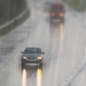

In [69]:
im1

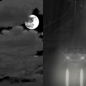

In [70]:
im2

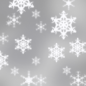

In [71]:
im3

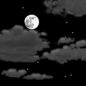

In [72]:
im4